#  JIGSAW MULTILINGUAL TOXIC COMMENT CLASSIFICATION


## Introduction

**Being anonymous over the internet can sometimes make people say nasty things that they normally would not in real life. Let's filter out the hate from our platforms one comment at a time.**

## Data overview :

**The dataset here is from wiki corpus dataset which was rated by human raters for toxicity. The corpus contains 63M comments from discussions relating to user pages and articles dating from 2004-2015.**

**Different platforms/sites can have different standards for their toxic screening process. Hence the comments are tagged in the following five categories**

# Steps involved :
 1. Import necessary modules
 2. Exploratory data analysis
 3. Tokenizing
 4. Embedding
 5. Data load and padding
 6. Create and compile model
 7. Model training
 8. Predictions, output -> submission.csv

## Start with importing necessary modules and pacakges

In [14]:
!pip install -q pyicu
!pip install -q pycld2
!pip install -q textstat
!pip install -q polyglot
!pip install -q googletrans

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import tensorflow as tf

In [20]:
# TF Imports
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, CuDNNLSTM, CuDNNGRU, Dropout, Bidirectional, Conv1D, Input
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import SpatialDropout1D, GlobalAveragePooling1D, GlobalMaxPooling1D, concatenate
from tensorflow.python.keras.layers.embeddings import Embedding
from tensorflow.python.keras.preprocessing import sequence
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.keras.optimizers import Adam
from tensorflow.python.keras.callbacks import EarlyStopping, LearningRateScheduler
# Numpy
import numpy
numpy.random.seed(1331)
# Pandas
import pandas as pd
# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold, cross_val_score
# Visualizations
import matplotlib.pyplot as plt
%matplotlib inline
# Garbage Collector
import gc
import sys
# Hyperopt
from hyperopt import fmin, tpe, hp, anneal, Trials, space_eval
# Random
import random
# codecs + collections + csv
import codecs
import collections
import csv
from scipy import stats
from colorama import Fore, Back, Style, init
import string
import math
import numpy as np
import scipy as sp
import pandas as pd
import scipy.stats as ss

import random
import networkx as nx
from pandas import Timestamp

from PIL import Image
from IPython.display import SVG
from keras.utils import model_to_dot
import string
import requests
from IPython.display import HTML

import seaborn as sns
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.pyplot as plt

tqdm.pandas()

import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots


Using TensorFlow backend.


In [ ]:
tf.__version__

# ** EXPLORATORY DATA ANALYSIS**

In [15]:
validate=pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation-processed-seqlen128.csv')
validate.head()

,id,comment_text,lang,toxic,input_word_ids,input_mask,all_segment_id
0,0,Este usuario ni siquiera llega al rango de ...,es,0,"(101, 12515, 82849, 10414, 10294, 39190, 10113...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,Il testo di questa voce pare esser scopiazzato...,it,0,"(101, 10282, 29346, 10120, 14508, 19696, 22606...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1,"(101, 32286, 119, 101911, 11419, 27119, 10797,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0,"(101, 11916, 10824, 71339, 10245, 15499, 24542...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0,"(101, 47197, 20267, 10371, 14349, 66513, 31268...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [16]:
comment=pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train-processed-seqlen128.csv")
display(comment.head())
print("Shape:",comment.shape)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,input_word_ids,input_mask,all_segment_id
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,"(101, 27746, 31609, 11809, 24781, 10105, 70971...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,"(101, 141, 112, 56237, 10874, 106, 10357, 1825...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,"(101, 35936, 10817, 117, 146, 112, 181, 30181,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,"(101, 107, 15946, 146, 10944, 112, 188, 13086,...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,"(101, 11065, 117, 52523, 117, 10301, 15127, 51...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


Shape: (223549, 11)


In [17]:
validation=pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/validation.csv")
display(validation.head())
print('shape:',validation.shape)

,id,comment_text,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,tr,0


shape: (8000, 4)


In [18]:
test_processed=pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test-processed-seqlen128.csv")
display(test_processed.head())
print('shape:',test_processed.shape)

,id,comment_text,input_word_ids,input_mask,all_segment_id
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,"(101, 17376, 14516, 19165, 56324, 10116, 24542...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"Вполне возможно, но я пока не вижу необходимо...","(101, 511, 53204, 36689, 44504, 117, 11279, 57...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"Quindi tu sei uno di quelli conservativi , ...","(101, 35921, 17938, 13055, 13868, 11381, 10120...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,"(101, 59170, 16822, 99087, 10284, 83972, 51782...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,"(101, 131, 32070, 11759, 131, 11045, 23388, 10...","(1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","(0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


shape: (63812, 5)


In [19]:
train=pd.read_csv("/kaggle/input/jigsaw-multilingual-toxic-comment-classification/jigsaw-toxic-comment-train.csv")
display(train.head())
print("Shape:",train.shape)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


Shape: (223549, 8)


In [21]:
test=pd.read_csv('/kaggle/input/jigsaw-multilingual-toxic-comment-classification/test.csv')
display(test.head())
print("shape:",test.shape)

,id,content,lang
0,0,Doctor Who adlı viki başlığına 12. doctor olar...,tr
1,1,"Вполне возможно, но я пока не вижу необходимо...",ru
2,2,"Quindi tu sei uno di quelli conservativi , ...",it
3,3,Malesef gerçekleştirilmedi ancak şöyle bir şey...,tr
4,4,:Resim:Seldabagcan.jpg resminde kaynak sorunu ...,tr


shape: (63812, 3)


In [22]:
test['lang'].unique()

array(['tr', 'ru', 'it', 'fr', 'pt', 'es'], dtype=object)

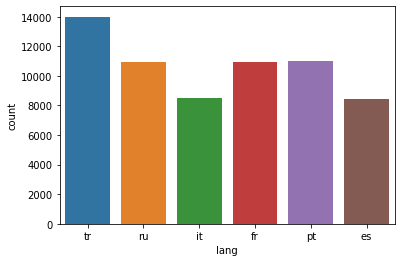

In [23]:
sns.countplot(test['lang'])

In [24]:
fig = go.Figure(data=[
    go.Pie(labels=train.columns[2:7],
           values=train.iloc[:, 2:7].sum().values, marker=dict(colors=px.colors.qualitative.Plotly))
])
fig.update_traces(textposition='outside', textfont=dict(color="black"))
fig.update_layout(title_text="Pie chart of labels")
fig.show()


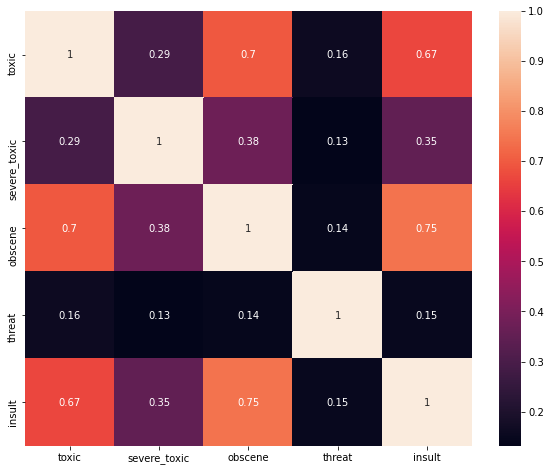

In [25]:
temp_df=train.iloc[:,2:-1]
# filter temp by removing clean comments
# temp_df=temp_df[~train.clean]

corr=temp_df.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, annot=True)


In [26]:
nrow_train=train.shape[0]
nrow_test=test.shape[0]
sum=nrow_train+nrow_test
print("       : train : test")
print("rows   :",nrow_train,":",nrow_test)
print("perc   :",round(nrow_train*100/sum),"   :",round(nrow_test*100/sum))

       : train : test
rows   : 223549 : 63812
perc   : 78    : 22


In [27]:
x=train.iloc[:,2:].sum()
#marking comments without any tags as "clean"
rowsums=train.iloc[:,2:].sum(axis=1)
train['clean']=(rowsums==0)
#count number of clean entries
train['clean'].sum()
print("Total comments = ",len(train))
print("Total clean comments = ",train['clean'].sum())
print("Total tags =",x.sum())

Total comments =  223549
Total clean comments =  201081
Total tags = 49596


In [28]:
print("Check for missing values in Train dataset")
null_check=train.isnull().sum()
print(null_check)

print("filling NA with \"unknown\"")
train["comment_text"].fillna("unknown", inplace=True)

Check for missing values in Train dataset
id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
clean            0
dtype: int64
filling NA with "unknown"


In [29]:
print("Check for missing values in Test dataset")
null_check=test.isnull().sum()
print(null_check)
print("filling NA with \"unknown\"")

Check for missing values in Test dataset
id         0
content    0
lang       0
dtype: int64
filling NA with "unknown"


In [30]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
train['none'] = 1-train[label_cols].max(axis=1)
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate,none
count,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000,223549.000000
mean,0.095657,0.008777,0.054306,0.003082,0.050566,0.009470,0.899494
std,0.294121,0.093272,0.226621,0.055431,0.219110,0.096852,0.300674
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


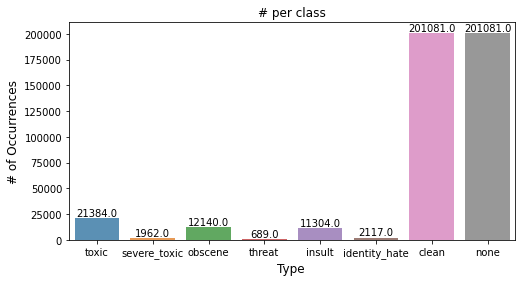

In [31]:
x=train.iloc[:,2:].sum()
#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("# per class")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('Type ', fontsize=12)
#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

## Let's see diffrent type of comments under diffrent categories


In [32]:
print("toxic:")
print(train[train.severe_toxic==1].iloc[3,1])

toxic:
Hi 

Im a fucking bitch.

50.180.208.181


In [33]:
print("severe_toxic:")
print(train[train.severe_toxic==1].iloc[4,1])

severe_toxic:
What a motherfucking piece of crap those fuckheads for blocking us!


In [34]:
print("Threat:")
print(train[train.threat==1].iloc[1,1])

Threat:
I think that your a Fagget get a oife and burn in Hell I hate you 'm sorry we cant have any more sex i'm running out of conndoms


In [35]:
print("Obscene:")
print(train[train.obscene==1].iloc[1,1])

Obscene:
You are gay or antisemmitian? 

Archangel WHite Tiger

Meow! Greetingshhh!

Uh, there are two ways, why you do erased my comment about WW2, that holocaust was brutally slaying of Jews and not gays/Gypsys/Slavs/anyone...

1 - If you are anti-semitian, than shave your head bald and go to the skinhead meetings!

2 - If you doubt words of the Bible, that homosexuality is a deadly sin, make a pentagram tatoo on your forehead go to the satanistic masses with your gay pals!

3 - First and last warning, you fucking gay - I won't appreciate if any more nazi shwain would write in my page! I don't wish to talk to you anymore!

Beware of the Dark Side!


In [36]:
print("identity_hate:")
print(train[train.identity_hate==1].iloc[4,1])

identity_hate:
u r a tw@ fuck off u gay boy.U r smelly.Fuck ur mum poopie


# Tokenize

First we need to read a good population of the data, in order to tokenize the data

In [4]:
# load training data
TRAIN_DATA_FILE = "../input/jigsaw-multilingual-toxic-comment-classification/jigsaw-unintended-bias-train.csv"
j_df = pd.read_csv(TRAIN_DATA_FILE)

# Parameter settings
maxlen = 220
max_features = 200000

# create a tokenizer
token = tf.keras.preprocessing.text.Tokenizer(num_words=max_features)
# fit tokenizer on data
token.fit_on_texts(j_df['comment_text'])
# get word index from tokenizer
word_index = token.word_index

# Memory Clean-up
del j_df
gc.collect()

32

# Validation

In [5]:
# load validation data
VAL_DATA_FILE = "../input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_valid_translated.csv"
j_df = pd.read_csv(VAL_DATA_FILE)
j_df.head(5)

,id,comment_text,translated,lang,toxic
0,0,Este usuario ni siquiera llega al rango de ...,This user does not even make it to the rank of...,es,0
1,1,Il testo di questa voce pare esser scopiazzato...,The text of this entry appears to be like I di...,it,0
2,2,Vale. Sólo expongo mi pasado. Todo tiempo pasa...,It is worth it. Only expose my past. All time ...,es,1
3,3,Bu maddenin alt başlığı olarak uluslararası i...,Of this article as a sub-heading with maintain...,tr,0
4,4,Belçika nın şehirlerinin yanında ilçe ve belde...,"I guess while they're At of the city, district...",tr,0


In [6]:

X_val = sequence.pad_sequences(token.texts_to_sequences(j_df['translated']), maxlen=maxlen)
y_val = j_df['toxic']
print(X_val.shape)

# Memory Clean-up
del j_df
gc.collect()

(8000, 220)


0

# Embedding

In [7]:
embed_size = 100

EMBEDDING_FILES = [
    '../input/jigsaw-custom-word2vec-100d-5iter/custom_word2vec_100d_5iter.txt'
]

def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path) as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in f)

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 100))
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            pass
    return embedding_matrix

embedding_matrix = np.concatenate([build_matrix(token.word_index, f) for f in EMBEDDING_FILES], axis=-1)
embedding_matrix = embedding_matrix[0:max_features,:]
embedding_matrix.shape

(200000, 100)

# Data Load & Padding

In [8]:
def sent_generator(TRAIN_DATA_FILE, chunksize, threshold, maxlen):
    reader = pd.read_csv(TRAIN_DATA_FILE, chunksize=chunksize, iterator=True)
    for df in reader:
        texts = df.iloc[:,1].astype(str)
        target = np.where(df.iloc[:,2]>threshold,1,0)
        sequences = token.texts_to_sequences(texts)
        data_train = sequence.pad_sequences(sequences, maxlen=maxlen)
        yield data_train, target

In [9]:
def test_data_prep():
    # load test data
    j_df = pd.read_csv("../input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv")
    X_test = j_df['translated'].astype(str)
    del j_df
    gc.collect()
    X_test = sequence.pad_sequences(token.texts_to_sequences(X_test), maxlen=maxlen)
    return X_test

X_test = test_data_prep()

# Create & Compile Model

In [10]:
# Results from Hyperopt
drpt_amt = 0.30
lstm2_nrns = 23
epochs = 1
batches = 641

In [11]:
def build_model():
    # create model
    model = Sequential()
    model.add(Embedding(max_features, embed_size, input_length=maxlen, weights=[embedding_matrix], trainable=False))
    model.add(Dropout(drpt_amt))
    model.add(Bidirectional(CuDNNLSTM(lstm2_nrns)))
    model.add(Dropout(drpt_amt))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Training

In [12]:
checkpoint_predictions = []
weights = []
nb_epoch = epochs
batch_size = batches
threshold = 0.48
for model_idx in range(2):
    model = build_model()
    n_steps = (1209267) // batch_size
    threshold += 0.02
    for counter in range(nb_epoch):
        print('-------epoch: ',counter,'--------')
        scheduler = lambda _: 1e-3 * (0.55 ** counter)
        callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
        model.fit_generator(sent_generator(TRAIN_DATA_FILE, batch_size, threshold, 220),
                            steps_per_epoch=n_steps, 
                            epochs=3, 
                            validation_data=(X_val, y_val),
                            callbacks=[callback])
        prediction = model.predict_proba(X_test).flatten()
        checkpoint_predictions.append(prediction)
        weights.append(2 ** counter)

-------epoch:  0 --------
Train for 1886 steps, validate on 8000 samples
Epoch 1/3
1886/1886 [==============================] - 174s 92ms/step - loss: 0.1638 - accuracy: 0.9465 - val_loss: 0.4711 - val_accuracy: 0.8644
Epoch 2/3
1082/1886 [================>.............] - ETA: 1:08 - loss: 0.1477 - accuracy: 0.9487-------epoch:  0 --------
Train for 1886 steps, validate on 8000 samples
Epoch 1/3
1886/1886 [==============================] - 165s 87ms/step - loss: 0.1651 - accuracy: 0.9454 - val_loss: 0.5675 - val_accuracy: 0.8625
Epoch 2/3
1081/1886 [================>.............] - ETA: 1:07 - loss: 0.1482 - accuracy: 0.9485

# Predictions and saving result in submission.csv

In [13]:
predictions = np.average(checkpoint_predictions, weights=weights, axis=0)

test_df = pd.read_csv("../input/jigsaw-multilingual-toxic-test-translated/jigsaw_miltilingual_test_translated.csv")
submission = pd.DataFrame.from_dict({
    'id': test_df.id,
    'toxic': predictions
})
submission.to_csv('submission.csv', index=False)
submission.head()

,id,toxic
0,0,0.002906
1,1,0.001528
2,2,0.008121
3,3,0.001128
4,4,0.003586
